<a href="https://colab.research.google.com/github/MariaMengozzi/esameDI/blob/main/Progetto_esame_DI_con_preprocessing_differenziato.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Determinare il prezzo di vendita delle auto

**Programmazione di Applicazioni Data Intensive**\
Laurea in Ingegneria e Scienze Informatiche\
DISI - Università di Bologna, Cesena

Maria Mengozzi

Per prima cosa carichiamo le librerie necessarie ad elaborare i dati:


*   *os.path* per elaborare i percorsi dei file
*   *NumPy* per creare e operare su array N dimesionali
*   *pandas* per caricare e manipolare dati tabulari
*   *matplotlib* e *seaborn* per creare grafici, viene inoltre aggiunta il comando per visualizzarli all'interno del notebook.


In [109]:
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 1 - Descrizione del problema, comprensione e analisi esplorativa dei dati


## Descrizione del problema

Carichiamo il dataset da [Kaggle](https://www.kaggle.com/nehalbirla/vehicle-dataset-from-cardekho?select=Car+details+v3.csv) contenente le informazioni sulle auto usate elencate su [www.cardekho.com](www.cardekho.com). 

L' obiettivo del progetto è quello di predire una variabile continua, ossia il prezzo di vendita di un' auto usata in base alle sue caratteristiche.

In [110]:
file_zip_url = "https://github.com/MariaMengozzi/esameDI/raw/main/UsedCarsDataset.zip"
file_zip_name = "UsedCarsDataset.zip"
file_name = 'Car details v3.csv'

if not os.path.exists(file_zip_name):
    from urllib.request import urlretrieve
    urlretrieve(file_zip_url, file_zip_name)
    from zipfile import ZipFile
    with ZipFile(file_zip_name) as f:
        f.extractall()

In [111]:
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",")

## Comprensione dei dati e analisi esplorativa

Analizziamo ora i dati. 

Il dataset contiene 8128 istanze e 13 features.


In [112]:
data.shape

(8128, 13)

In [113]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0


Le 13 **feature** presenti nel dataset sono:

* `name` : nome dell'auto
* `year` : anno in cui l'auto è stata comprata la prima volta
*	`km_driven` : numero di chilometri percorsi dall'auto
*	`fuel` : tipo di carburante utilizzato dall'auto
  - `Diesel` se a diesel
  - `Petrol` se a benzina
  - `LGP`  se a GPL
  - `CNG ` se a metano
*	`seller_type`	: indica il tipo di venditore
  - `Individual` se il venditore era un privato
  - `Dealer` se il venditore era un rivenditore
  - `Trustmark Dealer` se il venditore era un rivenditore specializzato
* `transmission` : tipo di trasmissione dell'auto 
  - `manual` se il cambio è manuale
  - `automatic` se il cambio è automatico
* `owner` : numero di proprietari precedenti
  - `First Owner` se l'auto ha avuto un solo proprietario
  - `Secondo Owner` se l'auto ha avuto due proprietari
  - `Third Owner` se l'auto ha avuto tre proprietari
  - `Fourth & Above Owner` se l'auto ha avuto quattro o più proprietari
  - `Test Drive Car` se l'auto non ha avuto proprietari, ma era una test car
* `mileage`	: distanza per unità di carburante
* `engine` :  cilindrata dell'auto
* `max_power`	: potenza massima del motore
* `torque`	: coppia motore, ovvero quanta potenza ci vuole perché l'auto raggiunga una certa velocità.
* `seats` : numero di sedili nell'auto

La variabile che tenteremo di predire è:
*	`selling_price` : prezzo di vendita dell'auto espresso in _rupie_ indiane




Osserviamo ora la tipologia delle variabili, in modo da capire se è possibile risparmiare spazio in memoria

In [114]:
data.dtypes

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
dtype: object

In [115]:
data.info(verbose=False, memory_usage="deep");

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: float64(1), int64(3), object(9)
memory usage: 5.0 MB


Come si può notare, molte delle feature sono rappresentate da oggetti. Osservando però il dataset si nota che è possibile gestire alcuni dati come categorici, nello specifico `seller_type`, `transmission`, `fuel` e `owner`. Verifichiamo ora i valori che possono assumere tali feature.




In [116]:
data['seller_type'].value_counts()

Individual          6766
Dealer              1126
Trustmark Dealer     236
Name: seller_type, dtype: int64

In [117]:
data['transmission'].value_counts()

Manual       7078
Automatic    1050
Name: transmission, dtype: int64

In [118]:
data['fuel'].value_counts()

Diesel    4402
Petrol    3631
CNG         57
LPG         38
Name: fuel, dtype: int64

In [119]:
data['owner'].value_counts()

First Owner             5289
Second Owner            2105
Third Owner              555
Fourth & Above Owner     174
Test Drive Car             5
Name: owner, dtype: int64

Ricarichiamo quindi il dataset specificando quali dati gestire come categorici.

In [120]:
categorical = ["seller_type", "transmission", "fuel", 'owner']
with open(file_name) as dataFile:
    data = pd.read_csv(dataFile, sep=",",  dtype={x:"category" for x in categorical})

print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8128 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(1), int64(3), object(5)
memory usage: 3.0 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage            object
engine             object
max_power          object
torque             object
seats             float64
dtype: object


Si può notare come già la dimensione sia diminuita.

## Rilevazione di valori mancanti

Verifichiamo ora se sono presenti valori mancanti

In [121]:
data.isnull().sum()

name               0
year               0
selling_price      0
km_driven          0
fuel               0
seller_type        0
transmission       0
owner              0
mileage          221
engine           221
max_power        215
torque           222
seats            221
dtype: int64

Procediamo rimuovendo i valori mancanti trovati nelle feature `mileage`, `engine`, `max_power`, `torque` e `seats`

In [122]:
data.dropna(inplace=True)
#verifichiamo che siano stati rimossi
data.isnull().sum()

name             0
year             0
selling_price    0
km_driven        0
fuel             0
seller_type      0
transmission     0
owner            0
mileage          0
engine           0
max_power        0
torque           0
seats            0
dtype: int64

In [123]:
data.shape

(7906, 13)

La dimensione del dataset è diminuita da 8128 a 7906 eliminando quindi 222 istanze

In [124]:
data.head(10)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74 bhp,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52 bhp,250Nm@ 1500-2500rpm,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7 kmpl,1497 CC,78 bhp,"12.7@ 2,700(kgm@ rpm)",5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90 bhp,22.4 kgm at 1750-2750rpm,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2 bhp,"11.5@ 4,500(kgm@ rpm)",5.0
5,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86 bhp,113.75nm@ 4000rpm,5.0
6,Maruti Wagon R LXI DUO BSIII,2007,96000,175000,LPG,Individual,Manual,First Owner,17.3 km/kg,1061 CC,57.5 bhp,"7.8@ 4,500(kgm@ rpm)",5.0
7,Maruti 800 DX BSII,2001,45000,5000,Petrol,Individual,Manual,Second Owner,16.1 kmpl,796 CC,37 bhp,59Nm@ 2500rpm,4.0
8,Toyota Etios VXD,2011,350000,90000,Diesel,Individual,Manual,First Owner,23.59 kmpl,1364 CC,67.1 bhp,170Nm@ 1800-2400rpm,5.0
9,Ford Figo Diesel Celebration Edition,2013,200000,169000,Diesel,Individual,Manual,First Owner,20.0 kmpl,1399 CC,68.1 bhp,160Nm@ 2000rpm,5.0


## Conversione del tipo di dato

Osservando sempre il dataset ci si accorge che i valori di alcune feature potrebbero essere considerati come numerici se si togliesse l'unità di misura. Le feature in questione sono:
* `mileage`
* `engine`
* `max_power`
* `torque` per quest'ultima sarà necessario isolare il valore del Nm (Newton*Metro) in quanto solo tale valore rappresenta la vera e propria coppia dell'auto

Procediamo quindi rimuovendo l'unità di misura e cambiando il tipo di dato.

In [125]:
data.mileage = data.mileage.str.replace(' kmpl','')
data.mileage = data.mileage.str.replace(' km/kg','')
data.engine = data.engine.str.replace(' CC','')
data.max_power = data.max_power.str.replace(' bhp','')
#per la coppia motore estraiamo il primo valore numerico
data['torque'] = data.torque.str.extract('(\d+[.\d]*)')

In [126]:
data.head(5)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4,1248,74,190,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250,5.0
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.7,1497,78,12.7,5.0
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0,1396,90,22.4,5.0
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1,1298,88.2,11.5,5.0


In [127]:
#convertiamo ora i dati da oggetto al tipo numerico più opportuno
data['mileage'] = data.mileage.astype(float)
data['engine'] = data.engine.astype(int)
data['max_power'] = data.max_power.astype(float)
data['torque'] = data.torque.astype(float)
# poichè i posti in auto non possono essere valori floating point li convertiamo ad intero
data['seats'] = data.seats.astype(int)

In [128]:
print(data.info(verbose=False, memory_usage="deep"))
print()
print(data.dtypes)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7906 entries, 0 to 8127
Columns: 13 entries, name to seats
dtypes: category(4), float64(3), int64(5), object(1)
memory usage: 1.2 MB
None

name               object
year                int64
selling_price       int64
km_driven           int64
fuel             category
seller_type      category
transmission     category
owner            category
mileage           float64
engine              int64
max_power         float64
torque            float64
seats               int64
dtype: object


Abbiamo così ottenuto una riduzione della dimensione del dataset da 5.0 MB iniziali a 1.2 MB, assegnando ad ogni feature il tipo di dato più opportuno a rappresentarla

In [129]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5


## Analisi generale dei dati

Visualizziamo alcune statistiche per prendere coscienza dei dati che dovremo analizzare e delle caratteristiche del dominio applicativo.

Vediamo come prima cosa quanto variano i dati in nostro possesso:

In [130]:
val_unici = []
for x in data.columns:
    val_unici.append(data[x].nunique())
pd.Series(val_unici, index=data.columns)

name             1982
year               27
selling_price     670
km_driven         898
fuel                4
seller_type         3
transmission        2
owner               5
mileage           381
engine            121
max_power         318
torque            244
seats               9
dtype: int64

Aggiungiamo una feature `years_driven` indicante gli anni che l'auto è in circolazione rispetto l'anno corrente (2021) in modo che sia intuibile più facilmente l'età dell'auto.

In [131]:
current_year = 2021
years_driven = 2021 - data['year']
data['years_driven'] = years_driven

In [132]:
data.head()

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,years_driven
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,5,7
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,5,7
2,Honda City 2017-2020 EXi,2006,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,5,15
3,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,5,11
4,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,5,14


Per capire meglio i dati visualizziamone alcuini su dei grafici opportuni

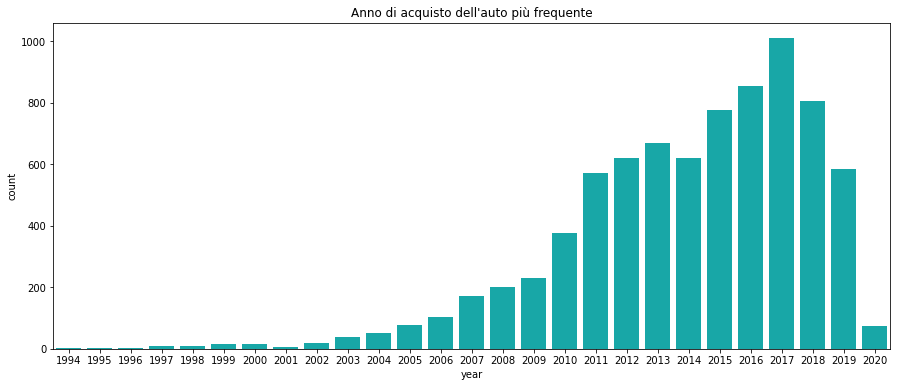

In [133]:
plt.figure(figsize=(15,6))
sns.countplot(x="year", data=data, color='c').set_title("Anno di acquisto dell'auto più frequente");


Notiamo che l'anno di primo acquisto, il 2017 è l'anno in cui sono state acquistate più auto.

<Figure size 720x288 with 0 Axes>

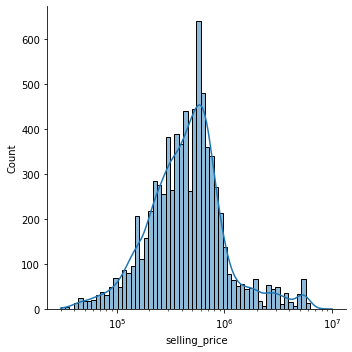

In [134]:
plt.figure(figsize=(10,4));
sns.displot(data, x="selling_price",  kde=True, log_scale=True);

Per il prezzo di vendita, ovvero la feature da predire, si può notare come i prezzi varino molto tra le auto vendute, ma vi è un'evevata concentrazione di prezzi tra 100.000 e 1.000.000

### Numero di posti auto

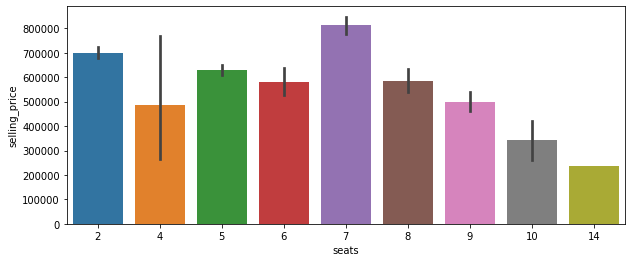

In [135]:
plt.figure(figsize=(10,4));
sns.barplot(x='seats',y='selling_price',data=data);

Notiamo che Le auto con 7 posti hanno un prezzo di vendita più elevato rispetto alle altre, sono poi seguite da quelle da 2 posti e da 5. Quelle vendute ad un prezzo più basso risultano con 14 posti.

Le barre nere indicano l'errore con un intervallo di confidenza del 95%, ossia danno un'idea generale di quanto sia precisa una misurazione o, al contrario, di quanto lontano dal valore riportato potrebbe essere il valore vero (privo di errori). In questo caso notiamo che vi è poca precisione per quanto riguarda le auto con 4 posti ciò significa che il loro valore è più variabile, mentre risulta più elevata per quelle a 14 e 2 posti.

### Numero di precedenti proprietari

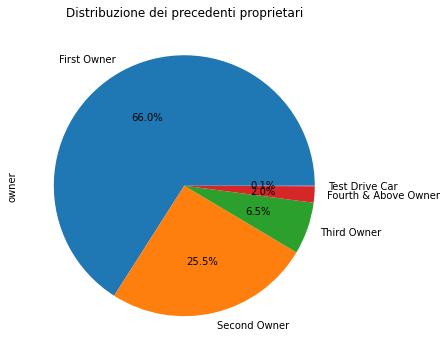

In [136]:
plt.figure(figsize=(10,6));
data['owner'].value_counts().plot.pie(autopct='%1.1f%%').set_title('Distribuzione dei precedenti proprietari');


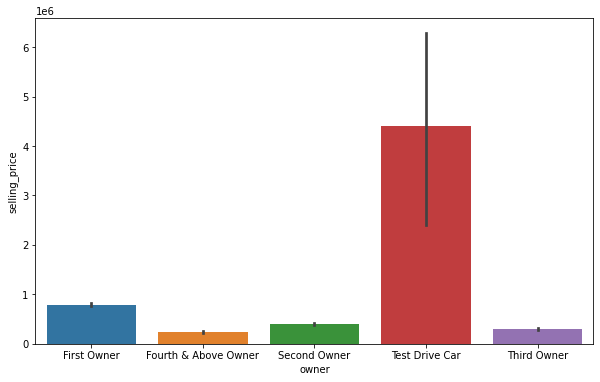

In [137]:
plt.figure(figsize=(10,6))
sns.barplot(x='owner',y='selling_price',data=data);

E' possibile notare come le auto del dataset abbiano avuto principalmente un solo proprietario prima di essere rivendute, ma che quelle vendute ad un prezzo maggiore risultano le test drive anche se più variabile rispetto alle altre.

### Tipo di venditore

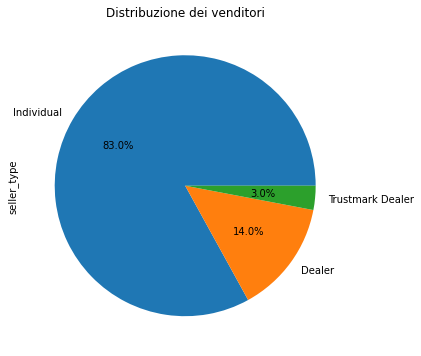

In [138]:
plt.figure(figsize=(10,6))
data['seller_type'].value_counts().plot.pie(autopct='%1.1f%%').set_title('Distribuzione dei venditori');


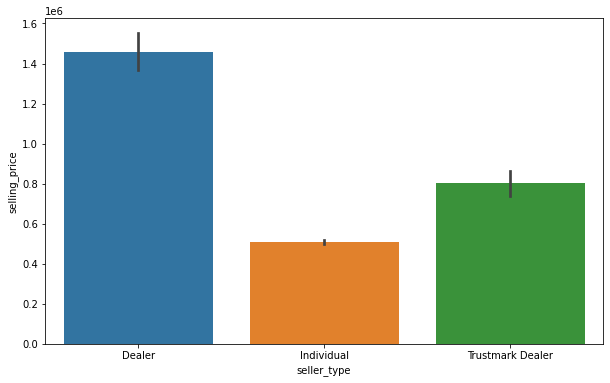

In [139]:
plt.figure(figsize=(10,6))
sns.barplot(x='seller_type',y='selling_price',data=data);

Vediamo una netta predominanza di venditori privati e solo una piccola percentuale di rivenditori di marchi di fiducia. Il prezzo di vendita delle auto risulta però maggiore nel caso dei rivenditori piuttosto che per i privati.

### Tipo di cambio

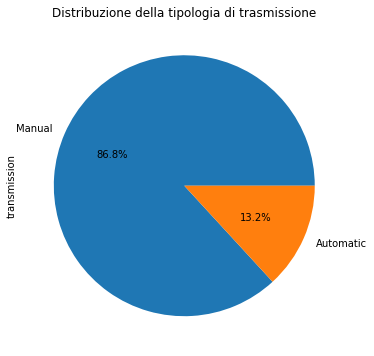

In [140]:
plt.figure(figsize=(10,6))
data['transmission'].value_counts().plot.pie(autopct='%1.1f%%').set_title('Distribuzione della tipologia di trasmissione');


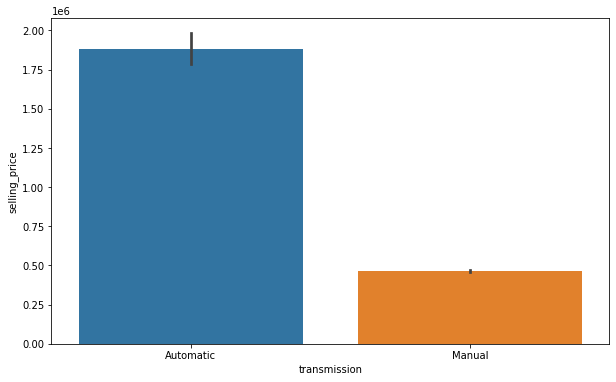

In [141]:
plt.figure(figsize=(10,6))
sns.barplot(x='transmission',y='selling_price',data=data);

Notiamo che la maggior parte delle auto vendute avevano un cambio manuale, ma che il loro prezzo di vendita è nettamente inferiore rispetto a quelle a cambio automatico.

### Tipo di carburante

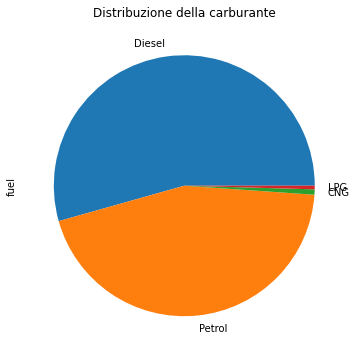

In [142]:
plt.figure(figsize=(10,6))
data['fuel'].value_counts().plot.pie().set_title('Distribuzione della carburante');


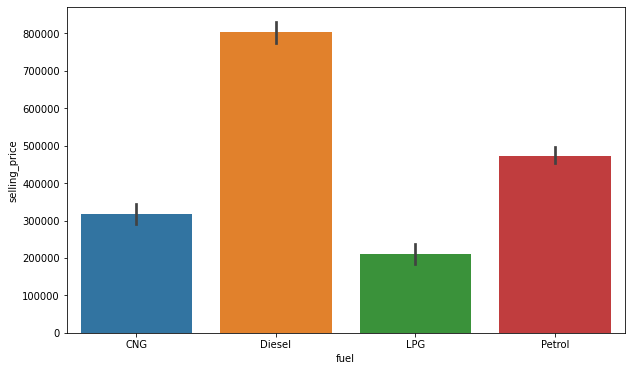

In [143]:
plt.figure(figsize=(10,6))
sns.barplot(x='fuel', y='selling_price', data = data);

Non vi è una siglificativa differenza tra auto a Diesel e Benzina le quali hanno un prezzo di vendita maggiore, mentre vi è una netta minoranza di CNG (Metano) e LPG (GPL) il cui prezzo risulta anche minore. 

### Chilometraggio - prezzo di vendita

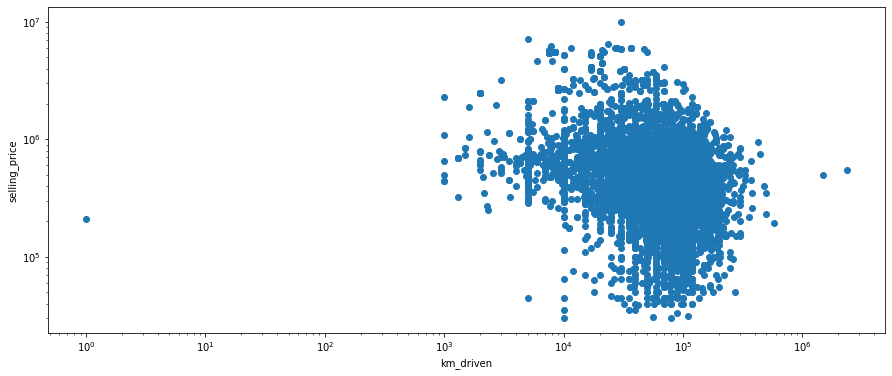

In [144]:
#essendo sia il prezzo che i chilometri sull'ordine delle migliaia, 
#utilizzo la scala logaritmica per visualizzare il grafico
plt.figure(figsize=(15,6))
plt.xscale('log')
plt.yscale('log')
plt.scatter(data['km_driven'],data['selling_price']);
plt.xlabel('km_driven');
plt.ylabel('selling_price');

Notiamo un'elevata concentrazione di prezzi sull'ordine di $10^5$ e $10^6$ per auto con un chilometraggio intorno a 100.000km

### Anni di circolazione - prezzo di vendita

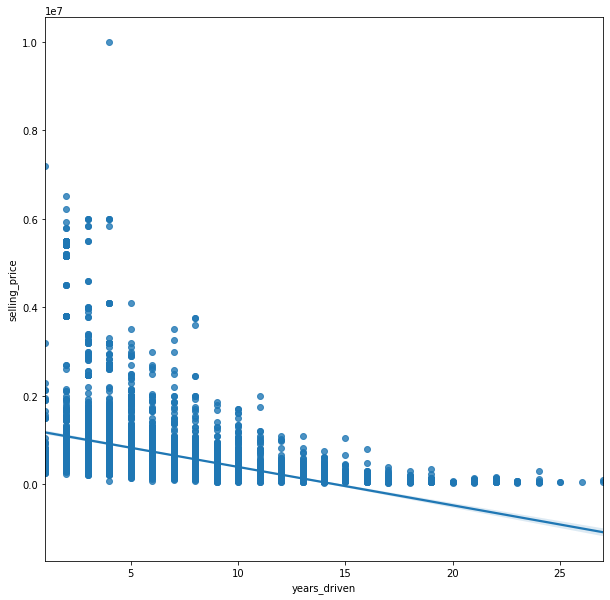

In [146]:
plt.figure(figsize=(10,10))
sns.regplot(x='years_driven',y='selling_price',data=data);

Mettendo a confronto gli anni di circolazione dell'auto e il prezzo di vendita è possibile notare come più gl'anni aumentino e più il prezzo diventi inferiore.

### Statistiche decrittive

In [37]:
data.describe()

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,years_driven
count,7906.000000,7.906000e+03,7.906000e+03,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000,7906.000000
mean,2013.983936,6.498137e+05,6.918866e+04,19.419861,1458.708829,91.587374,168.294141,5.416393,7.016064
std,3.863695,8.135827e+05,5.679230e+04,4.036263,503.893057,35.747216,97.313384,0.959208,3.863695
min,1994.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,32.800000,4.800000,2.000000,1.000000
25%,2012.000000,2.700000e+05,3.500000e+04,16.780000,1197.000000,68.050000,101.000000,5.000000,4.000000
50%,2015.000000,4.500000e+05,6.000000e+04,19.300000,1248.000000,82.000000,154.900000,5.000000,6.000000
75%,2017.000000,6.900000e+05,9.542500e+04,22.320000,1582.000000,102.000000,202.000000,5.000000,9.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,789.000000,14.000000,27.000000


Prendendo in considerazione le statistiche notiamo che:

*  l'auto più vecchia è del 1994, il che fa si che gli anni di circolazione siano pari a 27 (max(years_driven)), mente quella più recente è del 2020, con solo un anno di circolazione. Mediamente le auto vengono vendute dopo 7 anni
*   il prezzo medio di vendita è pari $649.813$. Tale feature ha un massimo pari a $10.000.000$ e un minimo di $29.999$. Il valore è molto variabile, lo si può notare dalla deviazione standard
* per quanto riguarda il chilometraggio delle auto mediamente è pari a $69.188$ km anch'esso è molto variabile
* il consumo medio al chilometro è di 19,4 l/km con dati più stabili rispetto agli altri
* il numero di posti in auto risulta quello con i dati meno sparsi, infatti ha una deviazione standard pari allo $0.95$

Visualizziamo tali dati mediante un boxplot



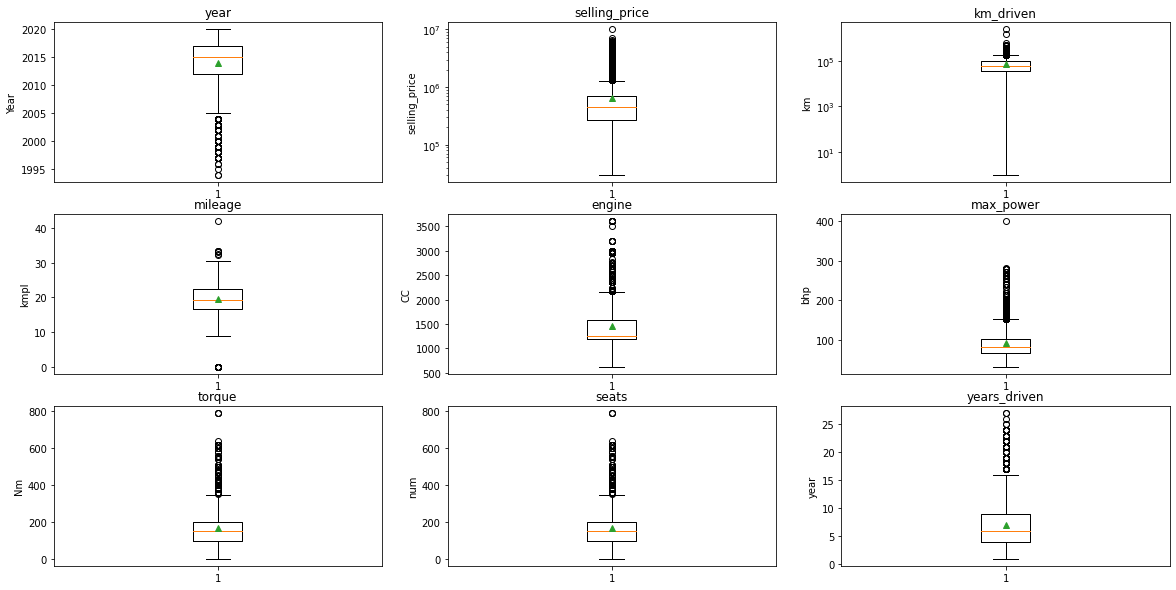

In [38]:
plt.figure(figsize=(20, 10))

plt.subplot(3, 3, 1)
plt.title('year')
plt.boxplot(data['year'],showmeans=True)
plt.ylabel('Year')

plt.subplot(3, 3, 2)
plt.title('selling_price')
plt.yscale('log')
plt.boxplot(data['selling_price'],showmeans=True)
plt.ylabel('selling_price')

plt.subplot(3, 3, 3)
plt.title('km_driven')
plt.yscale('log')
plt.boxplot(data['km_driven'],showmeans=True)
plt.ylabel('km')

plt.subplot(3, 3, 4)
plt.title('mileage')
plt.boxplot(data['mileage'],showmeans=True)
plt.ylabel('kmpl')

plt.subplot(3, 3, 5)
plt.title('engine')
plt.boxplot(data['engine'],showmeans=True)
plt.ylabel('CC')

plt.subplot(3, 3, 6)
plt.title('max_power')
plt.boxplot(data['max_power'],showmeans=True)
plt.ylabel('bhp')

plt.subplot(3, 3, 7)
plt.title('torque')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('Nm')

plt.subplot(3, 3, 8)
plt.title('seats')
plt.boxplot(data['torque'],showmeans=True)
plt.ylabel('num')

plt.subplot(3, 3, 9)
plt.title('years_driven')
plt.boxplot(data['years_driven'],showmeans=True)
plt.ylabel('year')

plt.show()

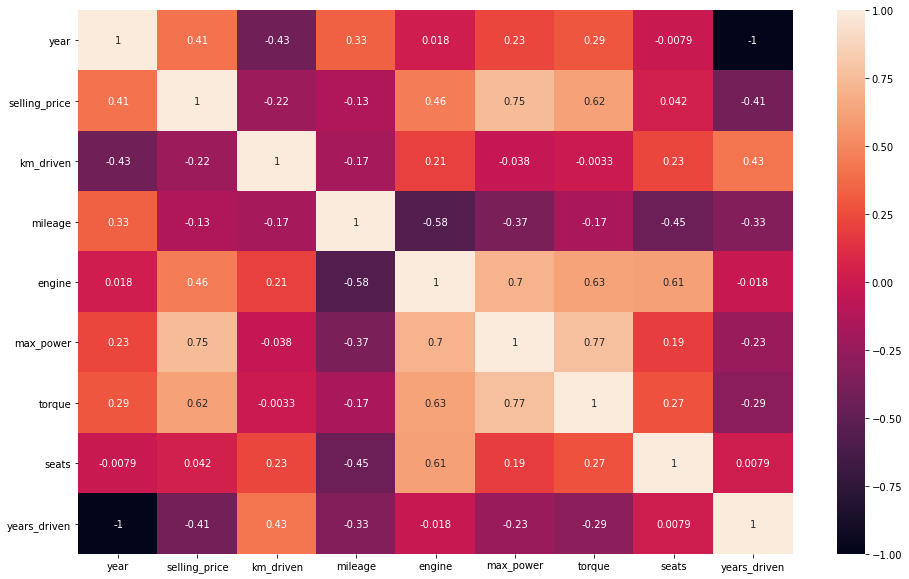

In [39]:
#plotting the heatmap
plt.figure(figsize=(16,10))
sns.heatmap(data.corr(),annot=True)
plt.show()

Producendo una matrice di correlazione delle features, possiamo osservare le seguenti correlazioni rilevanti:
* `selling_price` è correlato positivamente con `year`, `torque`, `max_power`, `engine` e anche se minimale con `seats`, al contrario sembra avere una correlazione negativa con `km_diven` e `mileage`.
* Come ci si poteva aspettare vi è un'elevata correlazione tra `max_power` e `engine`. La cilindrata, infatti, misura il volume d'aria teoricamente aspirato durante un ciclo fisico da una macchina volumetrica (il cilindro), più aria entra e più sarà elevata la potenza che il motore produce.
* Un'elevata correlazione è presente anche tra `max_power` e `torque`, ma anche questa deriva dal rapporto fisico tra le due feature. Infatti la potenza del motore è data da $Potenza = coppia * velocita' $
* Infine i chilometri percorsi `km_driven` dipendono, come ci si aspettava dall'anno in cui l'auto è stata acquistata `year` e quindi anche dagl'anni che l'auto è in circolazione `years_driven`.

# 2- Elaborazione delle features

In base alle considerazioni effettuate sulla base della correlazione, si decide di rimuovere la feature `seats` in quanto essere quella meno correlata al prezzo di vendita dell'auto. Essendo inoltre il nome delle auto ad alta variabilità, e l'anno di vendita indicabile mediante gl'anni di circolazione dell'auto, si decide di rimuoverli dal dataset.

In [148]:
data.drop(columns='seats', inplace=True)
data.drop(columns='name', inplace=True)
data.drop(columns='year', inplace=True)

In [149]:
data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


## Binarizzazione dei dati categorici
Procediamo ora a binarizzare i dati categorici, questo ci permetterà di poterli confrontare con gli altri dati e successivamente per la generazione dei modelli

La binarizzazione avverrà mediante il metodo **One Hot Encoding**

One Hot Encoding è un processo nell'elaborazione dei dati che viene applicato ai dati categorici, per convertirli in una rappresentazione vettoriale binaria da utilizzare negli algoritmi di apprendimento automatico.

Si convertono ora le features categoriche splittando i loro valori nelle rispettive classi di appartenenza creando una colonna per ogni classe. Nelle celle sarà presente un 1 solo in corrispondenza della classe di appartenenza e 0 negli altri casi.

In [150]:
from sklearn.preprocessing import OneHotEncoder # per applicare la binarizzazione delle variabili categoriche
from sklearn.compose import ColumnTransformer #per applicare preprocessing differenziato

Definiamo già quali feature sono numeriche, questo ci servirà poi per applicare un preprocessing differenziato alle features.

In [151]:
numerical = data.columns[~data.columns.isin(categorical + ['selling_price'])]
numerical

Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')

Visualizziamo come verranno convertite le celle categoriche

In [152]:
encoder = OneHotEncoder(sparse=False) 
X_cat = data[categorical]

categorical_df = pd.DataFrame(
    encoder.fit_transform(X_cat),
    columns=encoder.get_feature_names(X_cat.columns)
)
categorical_df.head(5)

,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0


Utilizziamo una heatmap per visualizzare la correlazione tra le variabili del dataset finale. Lo stesso risultato ottenuto con OneHotEncoded è ottenibile con pd.get_dummies()

In [153]:
final_data = pd.get_dummies(data) 
#poichè utilizzerò la regolarizzazione al momento non specifico drop_firt=True, successivamente se necessario rimuoverò tali feature 
final_data.head()

,selling_price,km_driven,mileage,engine,max_power,torque,years_driven,fuel_CNG,fuel_Diesel,fuel_LPG,fuel_Petrol,seller_type_Dealer,seller_type_Individual,seller_type_Trustmark Dealer,transmission_Automatic,transmission_Manual,owner_First Owner,owner_Fourth & Above Owner,owner_Second Owner,owner_Test Drive Car,owner_Third Owner
0,450000,145500,23.40,1248,74.00,190.0,7,0,1,0,0,0,1,0,0,1,1,0,0,0,0
1,370000,120000,21.14,1498,103.52,250.0,7,0,1,0,0,0,1,0,0,1,0,0,1,0,0
2,158000,140000,17.70,1497,78.00,12.7,15,0,0,0,1,0,1,0,0,1,0,0,0,0,1
3,225000,127000,23.00,1396,90.00,22.4,11,0,1,0,0,0,1,0,0,1,1,0,0,0,0
4,130000,120000,16.10,1298,88.20,11.5,14,0,0,0,1,0,1,0,0,1,1,0,0,0,0


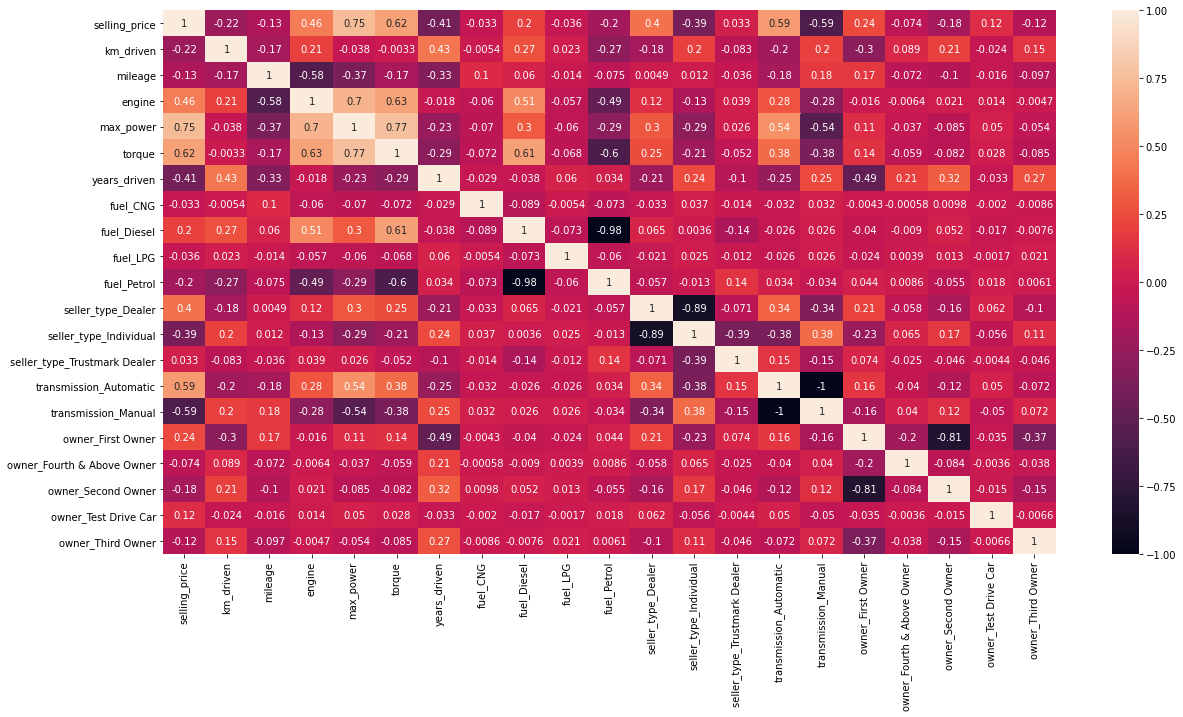

In [165]:
#plotting the heatmap
plt.figure(figsize=(20,10))
sns.heatmap(final_data.corr(),annot=True);

Analizzando la correlazione tra `selling_price` e  le variabili categoriche è possibile constatare che le auto che hanno avuto un solo proprietario hanno una correlazione positiva con il prezzo di vendita, così pure il cambio automatico, il diesel e come venditore un rivenditore, mentre il cambio manuale, il carburante di tipo benzina, un numero di proprietari maggiore a 2 e la vendita da parte di un privato hanno una correlazione negativa.

Utilizziamo ora la funzione pairplot di seaborn per comprendere la relazione tra le features e la variabile da predire.

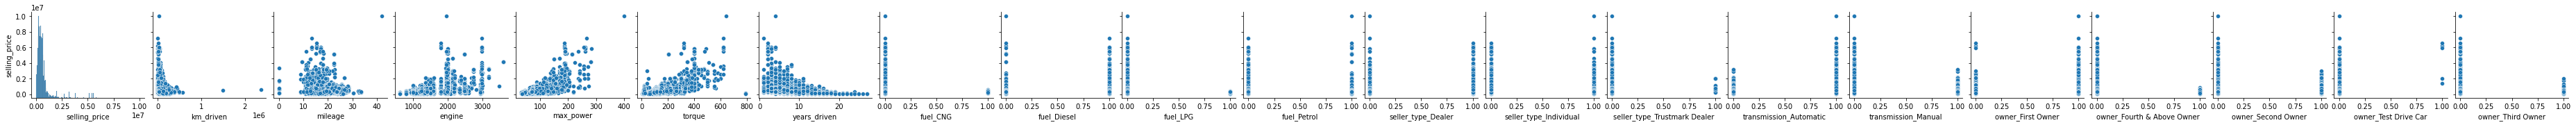

In [166]:
sns.pairplot(final_data, 
            y_vars=["selling_price"]);

## Standardizzazione, Regolarizzarione e selezione delle feature

Poichè le istanze del dataset hanno ordini di grandezza diversi si procede nelle fasi successive alla standardizzazione delle feature mediante StandardScaler al fine di uniformare i valori, ridimensionando la distribuzione dei valori in modo che la media dei valori osservati sia 0 e la deviazione standard sia 1. La standardizzazione verrà applicata anche alla variabile di output, ciò è possibile in quanto la loro distribuzione è simile ad una gaussiana


Importiamo come prima cosa le librerie necessarie.

In [167]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Dividiamo mediante il metodo di hold out i dati in training e validation set, assegnando al validation set 1/3 e al training set 2/3 dei dati

In [168]:
y = data['selling_price']
X = data.drop(columns="selling_price")

In [169]:
y.head()

0    450000
1    370000
2    158000
3    225000
4    130000
Name: selling_price, dtype: int64

In [170]:
X.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


In [171]:
X_train, X_val, y_train, y_val = train_test_split(X, y , test_size=0.3, random_state=42)

In [175]:
print(f'''Dimensione del Train-set -> {X_train.shape},
Dimensione del Validation-set -> {X_val.shape}''')

Dimensione del Train-set -> (5534, 10),
Dimensione del Validation-set -> (2372, 10)


Applico la standardizzazione delle y, ossia della mia variabile da predire

In [176]:
scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values[:, None]).ravel()
y_val = scaler_y.transform(y_val.values[:, None]).ravel()

Ora che il dataset è stato diviso procediamo alla creazione e alla valutazione dei modelli al fine di avere una prima conoscenza sulle features rimaste più importanti per il modello.

In [177]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [180]:
def relative_error(y_true, y_pred):
    y_real = scaler_y.inverse_transform(y_true)
    y_pred = scaler_y.inverse_transform(y_pred)
    return np.mean(np.abs((y_real - y_pred) / y_real))

In [186]:

#definiamo la metodologia di cross-validation da applicare 
kf = KFold(5, shuffle=True, random_state=42)

def pred_model(model):
    # Training model
    #model.fit(X_train,y_train)
            
    # R2 score of train set
    y_pred_train = model.predict(X_train)
    R2_train_model = r2_score(y_train,y_pred_train)
    #R2_train.append(round(R2_train_model,2))
    
    # R2 score of test set
    y_pred_val = model.predict(X_val)
    R2_test_model = r2_score(y_val,y_pred_val)
    #R2_test.append(round(R2_test_model,2))
    
    # R2 mean of train set using Cross validation
    #cross_val = cross_val_score(model, X_train , y_train ,cv=kf)
    #cv_mean = cross_val.mean()
    
    # Printing results
    #print("Mean squared error :",round(mean_squared_error(y_val, y_pred_val),2))
    print("Relative error : ",round(relative_error(y_val, y_pred_val),2))
    print("Train R2-score :",round(R2_train_model,2))
    print("Test R2-score :",round(R2_test_model,2))
    #print("Train CV scores :",cross_val)
    #print("Train CV mean :",round(cv_mean,2))
    print(pd.Series(model.named_steps['reg'].coef_, final_data.drop(columns=['selling_price']).columns))


Utilizzeremo la regressione Lasso con vari valori di L1 per verificare se sono presenti delle feature meno rilevanti.


In [182]:
from sklearn.model_selection import GridSearchCV

In [196]:
lasso_grid = Pipeline([
    ('preproc', ColumnTransformer([
                 ('categorical', OneHotEncoder(), categorical)],remainder=StandardScaler())),
    ("reg",  Lasso(random_state=42))
])

grid = {
    "reg__alpha": np.arange(0, 5, 0.01) #np.arange(0, 1, 0.01)
}
gs = GridSearchCV(lasso_grid, grid, cv=kf, refit=True)
gs.fit(X_train, y_train);
pd.DataFrame(gs.cv_results_).sort_values("mean_test_score", ascending=False)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 715.1365921809727, tolerance: 0.45308693940494854
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coo

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_reg__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.153614,0.009797,0.009611,0.001581,0,{'reg__alpha': 0.0},0.661665,0.666266,0.670089,0.689200,0.689207,0.675285,0.011673,1
1,0.039064,0.009133,0.011550,0.004469,0.01,{'reg__alpha': 0.01},0.674083,0.654415,0.667904,0.688498,0.671742,0.671328,0.010958,2
2,0.023918,0.003005,0.007871,0.000199,0.02,{'reg__alpha': 0.02},0.668453,0.653353,0.662321,0.685411,0.664218,0.666751,0.010551,3
3,0.026990,0.006868,0.008476,0.001809,0.03,{'reg__alpha': 0.03},0.659934,0.648934,0.653535,0.679244,0.654209,0.659171,0.010627,4
4,0.027083,0.009380,0.009414,0.003963,0.04,{'reg__alpha': 0.04},0.648342,0.641099,0.641662,0.672694,0.641596,0.649079,0.012107,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
213,0.024564,0.008783,0.007746,0.000262,2.13,{'reg__alpha': 2.13},-0.001049,-0.001098,-0.000680,-0.000887,-0.000031,-0.000749,0.000387,77
212,0.026072,0.007609,0.009909,0.003346,2.12,{'reg__alpha': 2.12},-0.001049,-0.001098,-0.000680,-0.000887,-0.000031,-0.000749,0.000387,77
211,0.024375,0.003898,0.008229,0.000330,2.11,{'reg__alpha': 2.11},-0.001049,-0.001098,-0.000680,-0.000887,-0.000031,-0.000749,0.000387,77
210,0.029619,0.011328,0.012851,0.004382,2.1,{'reg__alpha': 2.1},-0.001049,-0.001098,-0.000680,-0.000887,-0.000031,-0.000749,0.000387,77


In [197]:
print(gs.best_params_)

{'reg__alpha': 0.0}


Essendo lambda pari a 0 vuol dire che non vine applicata la norma L1 e quindi tutte le variabili saranno utilizzate, è come se stessimo utilizzando una semplice regressione lineare senza l'applicazione della penalizzazione. Analizziamo il modello addestrato per capire come vengono utilizzate le features per predire il valore del prezzo di vendita.

In [198]:
pred_model(gs.best_estimator_)

/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 715.1365921809727, tolerance: 0.45308693940494854
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coo

Relative error :  0.74
Train R2-score : 0.68
Test R2-score : 0.69
Train CV scores : [0.66166539 0.66626621 0.67008877 0.68919964 0.689207  ]
Train CV mean : 0.68
km_driven                       3.033161e-01
mileage                         2.180160e-02
engine                         -8.567780e-02
max_power                       5.582501e-01
torque                          7.744192e-14
years_driven                    7.533421e-02
fuel_CNG                        2.793277e-02
fuel_Diesel                     3.278489e-01
fuel_LPG                       -3.953567e-03
fuel_Petrol                     4.593372e-02
seller_type_Dealer              9.437104e-02
seller_type_Individual         -1.667497e-02
seller_type_Trustmark Dealer    2.870294e+00
transmission_Automatic          3.273113e-03
transmission_Manual            -9.078419e-02
owner_First Owner               7.595167e-02
owner_Fourth & Above Owner      4.018996e-02
owner_Second Owner              5.533384e-01
owner_Test Drive Car        

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 708.3290824945435, tolerance: 0.4412629319426492
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/pipeline.py:354: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  self._final_estimator.fit(Xt, y, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 696.9683303177083, tolerance: 0.4339854234114938
  positive)


Dai segni dei coefficienti possiamo vedere quali fenomeni influiscono positivamente e negativamente sul prezzo di vendita. Ad esempio notiamo che il prezzo aumenta per le auto vendute da un rivenditore specializzato e con una potenza elevata, mentre diminuisce se il numero di proprietari precedenti è 3.

Poichè come detto, non viene applicata nessuna penalizzazione e conseguentemente non viene rimossa nessuna feature, il dataset finale corrisponderà a quello ottenuto in precedenza rimuovendo il nome dell'auto gli anni e il numero di sedili.

In [199]:
final_data = data.copy()

In [200]:
final_data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
1,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.0,7
2,158000,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.7,15
3,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.4,11
4,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.5,14


## Estrazione del Test-set

Estraiamo alcuni dati dal dataset in modo da ottenere un dataFrame utilizzabile come test una volta trovato il modello più adeguato.

In [201]:
final_data.shape #shape originale di final_data

(7906, 11)

In [202]:
test_data = final_data[::20]
test_data.shape

(396, 11)

In [203]:
final_data = final_data[~final_data.index.isin(test_data.index)]

In [204]:
final_data.shape #shape finale di final_data

(7510, 11)

Procediamo ora ridividendo il dataset

In [205]:
y = final_data['selling_price']
X = final_data.drop(columns="selling_price")

In [206]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

In [207]:
print(f'''Dimensione del Train-set -> {X_train.shape},
Dimensione del Validation-set -> {X_val.shape}''')

Dimensione del Train-set -> (5006, 10),
Dimensione del Validation-set -> (2504, 10)


In [208]:
X.head()

,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
1,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,7
2,140000,Petrol,Individual,Manual,Third Owner,17.70,1497,78.00,12.70,15
3,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,22.40,11
4,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,11.50,14
5,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,4


In [209]:
y_train = scaler_y.fit_transform(y_train.values[:, None]).ravel()
y_val = scaler_y.transform(y_val.values[:, None]).ravel()

# 3- Modellazione

Il nostro obiettivo finale è quello di ottenere un modello di regressione sui dati in modo da poter ottenere direttamente il prezzo di vendita delle auto.

Andiamo quindi a testare alcune tecniche di regressione per valutare quella che meglio si presta al nostro tipo di problema.

Oltre a quello precedentemente visto durante la fase di selezione delle features saranno testati altri modelli di regressione sul dataset aggiornato. Faremo uso di **Grid Search** e **K-fold cross validation** saranno quindi generati 5 modelli differenti in grado di stimare gli iperparametri e permettere il calcolo dell'accuratezza dei modelli studiati.

Definiamo alcune funzioni che ci permetteranno di valutare i modelli. Inizializziamo anche un dizionario dove memorizzeremo i valori del MSE, errore relativo e coefficiente $R^2$ in modo poi da poter confrontare i modelli.

In [211]:
models = {}
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

def print_k_cross_validation_scores(model, X, y, kf):
    scores = cross_val_score(model, X, y, cv=kf)
    print("            Scores: {}\n              Mean: {}\nStandard deviation: {}".format(scores, scores.mean(), scores.std()))

def grid_search_with_cross_validation(model, grid, kf):
    grid_search = GridSearchCV(model, grid, cv=kf, refit=True)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=1/3, random_state=42)

    y_train = scaler_y.fit_transform(y_train.values[:, None]).ravel()
    y_val = scaler_y.transform(y_val.values[:, None]).ravel()

    grid_search.fit(X_train, y_train)
    

    print("Best cross validation score: {}\n".format(grid_search.best_score_))
    print("                Best params: {}\n".format(grid_search.best_params_))
    print("             Best estimator: {}\n".format(grid_search.best_estimator_))

    preds = grid_search.best_estimator_.predict(X_val)
    MSE = mean_squared_error(y_val, preds)
    RE = relative_error(y_val, preds)
    R2 = r2_score(y_val, preds)
    print("   Mean squared error: {:.5}".format(MSE))
    print("       Relative error: {:.5%}".format(RE))
    print("R-squared coefficient: {:.5}\n".format(R2))



    return grid_search.best_estimator_, MSE, RE, R2

## Linear Regression

In [212]:
%%time
linear_model = Pipeline([
                ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
                   ('reg', LinearRegression())
])
grid={}

linear_model, MSE, RE, R2 = grid_search_with_cross_validation(linear_model, grid, kfold)
models["Linear Regression"] = {"Model" : linear_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6836039776353084

                Best params: {}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                                              

Il modello lineare ha un indice $R^2$ abbastanza basso, il che significa che non descrive benissimo i dati. 

## Ridge Regression
Procediamo con una regressione di tipo Ridge, la quale applica una regolarizzazione L2, indicata dal parametro *alpha*, per ridurre la scala dei coefficienti.

In [213]:
%%time
ridge_model = Pipeline([
                   ("preproc", ColumnTransformer([
                        ("numeric", StandardScaler(), numerical),
                        ("categorical", OneHotEncoder(), categorical)
                    ])),
                   ('reg', Ridge(random_state=42))
])
grid={
    "reg__alpha": [0.1, 1, 10]
}

ridge_model, MSE, RE, R2 = grid_search_with_cross_validation(ridge_model, grid, kfold)
print_k_cross_validation_scores(ridge_model, X, y, kfold)
models["Ridge Regression"] = {"Model" : ridge_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6838090188611455

                Best params: {'reg__alpha': 1}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
                               

Anche applicando una regolarizzazione ai coefficienti il valore di $R^2$ non è migliorato, al contrario è aumentato sia l'MSE che l'errore relativo commesso sui dati.

## ElasticNet
Un altro possibile modello è ElasticNet, il quale oltre ad applicare la regolarizzazione mediante L2, permette anche di applicare la selezione delle feature derivante da Lasso applicando quindi anche L1.

In [214]:
%%time
elasticNet_model = Pipeline([
                   ("preproc", ColumnTransformer([
                        ("numeric", StandardScaler(), numerical),
                        ("categorical", OneHotEncoder(), categorical)
                    ])),
                   ('reg', ElasticNet(random_state=42))
])
grid={
    "reg__alpha": [0.1, 1, 10],
    "reg__l1_ratio": [0.1, 0.25, 0.5]
}

elasticNet_model, MSE, RE, R2 = grid_search_with_cross_validation(elasticNet_model, grid, kfold)
print_k_cross_validation_scores(elasticNet_model, X, y, kfold)
models["ElasticNet Regression"] = {"Model" : elasticNet_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.6675943943801783

                Best params: {'reg__alpha': 0.1, 'reg__l1_ratio': 0.1}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
       

Anche mediante ElasticNet il modello non migliora. Si procede quindi all'utilizzo di modelli non lineari.

## KernelRidge Regression

L'utilizzo di feature non lineari potrebbe migliorare il modello di regressione. Mediante la regressione polinomiale si eseguono prodotti tra dati con dimensioni aggiunte e rappresentate esplicitamente, ciò implica un aumento delle feature con il conseguente aumento dei tempi di addestramento.

Per far fronte all'aumento delle feature si utilizzano le *funzioni kernel*, tali funzioni permettono di calcolare gli stessi prodotti senza calcolare esplicitamente le dimensioni aggiunte. Esistono diversi tipi di kernel, per questo progetto utilizzeremo:
* kernel polinomiale: $K(\mathbf{a},\mathbf{b}) = \left(\mathbf{a}\cdot\mathbf{b}+c\right)^d $ , dove *d* è il grado del polinomio
* kernel RBF (radial basis function):  $K(\mathbf{a},\mathbf{b}) = exp(-{\frac{||\mathbf{a}-\mathbf{b}||_2 ^ 2}{2\sigma^2} })$

In [215]:
from sklearn.kernel_ridge import KernelRidge

In [216]:
#per disabilitare i warning
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

kernelRidge come si può intuire dal nome implementa la regressione ridge con l'applicazione di una funzione kernel. Anche per la sua applicazione faremo uso della gridSearch per individuare gli iperparametri migliori. 

In [217]:
%%time

kernel_ridge_poly_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", KernelRidge(kernel='poly'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__degree' : range(2, 5)
                      }
                  ]

kernel_ridge_poly_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_poly_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_poly_model, X, y, kfold)
models["KernelRidge poly Regression"] = {"Model" : kernel_ridge_poly_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9295484808598685

                Best params: {'reg__alpha': 1, 'reg__degree': 3}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
             

Come si può notare i tempi di esecuzione sono aumentati considerevolmente rispetto a quelli dei modelli lineari, ciò è dovuto al fatto che la complessità di training, mediante l'utilizzo delle funzioni kernel, è quadratica rispetto al numero di istanze. In ogni caso, mediante l'utilizzo di una funzione polinomiale, abbiamo ottenuto un miglioramento significativo nell'accuratezza del modello.

Utilizziamo una RBF ossia una funzione non lineare più complessa della polinomiale, che rappresenta i dati come combinazione lineare di k gaussiane, per vedere se il valore $R^2$ aumenta ulteriormente.
 

In [218]:
%%time

kernel_ridge_rbf_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", KernelRidge(kernel='rbf'))
])


kernel_ridge_grid = [
                     {'reg__alpha' :  [0.01, 0.1, 1, 10],
                      'reg__gamma' : [0.01, 0.1, 1, 10]
                      }
                  ]

kernel_ridge_rbf_model, MSE, RE, R2 = grid_search_with_cross_validation(kernel_ridge_rbf_model, kernel_ridge_grid, kfold)
print_k_cross_validation_scores(kernel_ridge_rbf_model, X, y, kfold)
models["KernelRidge rbf Regression"] = {"Model" : kernel_ridge_rbf_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.927849551753787

                Best params: {'reg__alpha': 0.01, 'reg__gamma': 0.01}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto',
         

Notiamo che l'utilizzo di una Gausian Radial Basis descrive meglio i dati, ottenendo così un valore $R^2$ pari al 94%

## Albero decisionale

L'albero decisionale costruisce modelli di regressione o classificazione sotto forma di una struttura ad albero. Suddivide un insieme di dati in sottoinsiemi sempre più piccoli mentre allo stesso tempo viene sviluppato in modo incrementale un albero decisionale associato. Il risultato finale è un albero con nodi decisionali e nodi foglia. 

In [219]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_text
from sklearn.tree import plot_tree

In [220]:
%%time
decisionTree_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", DecisionTreeRegressor(random_state=42))
])

decisionTree_grid = {
    'reg__max_depth': [3, 5, 10],
    "reg__min_samples_split": [2,0.02, 0.05, 0.1]

}

decisionTree_model, MSE, RE, R2 = grid_search_with_cross_validation(decisionTree_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(decisionTree_model, X, y, kfold)
models["decisionTreeRegressor"] = {"Model" : decisionTree_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9181304994144641

                Best params: {'reg__max_depth': 10, 'reg__min_samples_split': 2}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto

Visualizziamo i primi livelli dell'albero ottenuto

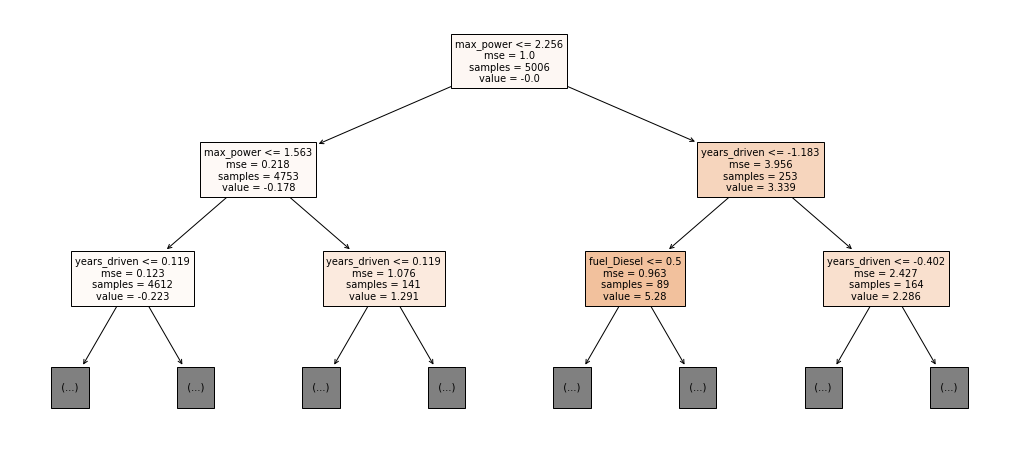

In [223]:
plt.figure(figsize=(18,8))
plot_tree(decisionTree_model.named_steps['reg'], 
          feature_names=list(pd.get_dummies(final_data.drop(columns=['selling_price'])).columns), 
          max_depth=2, filled=True);

In [224]:
decisionTree_model.named_steps['reg'].get_n_leaves()

351

In [85]:
#per una visione completa dell'albero decisionale
#from sklearn.tree import export_text, plot_tree
#print(export_text(decisionTree_model.named_steps['reg'], 
#                  feature_names=list(pd.get_dummies(final_data.drop(columns=['selling_price'])).columns)))

Mediante l'albero decisionale abbiamo ottenuto un ulteriore incremento di $R^2$. Procediamo ora con un modello che sfrutta gl'alberi decisionali per vedere se il modello migliora.

## Random forest

Una Random Forest è una tecnica di ensambe, ossia combina insieme le previsioni di più algoritmi di apprendimento automatico per fare previsioni più accurate rispetto a qualsiasi singolo modello, in grado di eseguire sia attività di regressione che di classificazione con l'uso di più alberi decisionali e una tecnica chiamata Bootstrap Aggregation, nota come bagging. 

Il bagging, nel metodo Random Forest, comporta l'addestramento di ciascun albero decisionale su un campione di dati diverso. Finito l'addestramento aggrega gli output senza fare preferenze per alcun modello 



In [225]:
from sklearn.ensemble import RandomForestRegressor

In [227]:
%%time
RandomForestRegressor_model = Pipeline([
    ("preproc", ColumnTransformer([
                    ("numeric", StandardScaler(), numerical),
                    ("categorical", OneHotEncoder(), categorical)
                ])),
    ("reg", RandomForestRegressor(random_state=42))
])
decisionTree_grid = {
    'reg__max_depth': [3, 5, 10],
    "reg__min_samples_split": [2, 0.02, 0.05, 0.1]
}

RandomForestRegressor_model, MSE, RE, R2 = grid_search_with_cross_validation(RandomForestRegressor_model, decisionTree_grid, kfold)
print_k_cross_validation_scores(RandomForestRegressor_model, X, y, kfold)
models["RandomForestRegressor"] = {"Model" : RandomForestRegressor_model, 'MSE': MSE, 'relative error': RE, 'R^2': R2}

Best cross validation score: 0.9536753325427479

                Best params: {'reg__max_depth': 10, 'reg__min_samples_split': 2}

             Best estimator: Pipeline(memory=None,
         steps=[('preproc',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('numeric',
                                                  StandardScaler(copy=True,
                                                                 with_mean=True,
                                                                 with_std=True),
                                                  Index(['km_driven', 'mileage', 'engine', 'max_power', 'torque',
       'years_driven'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(categories='auto

Anche dall'utilizzo del RandomForest otteniamo un buon risultato per quanto riguarda l'accuratezza del modello.

## Riepilogo accuratezze

In [228]:
pd.DataFrame(models)[1:].T

,MSE,relative error,R^2
Linear Regression,0.314638,0.77233,0.66192
Ridge Regression,0.314706,0.77318,0.661847
ElasticNet Regression,0.321683,0.706174,0.65435
KernelRidge poly Regression,0.080222,0.245868,0.913801
KernelRidge rbf Regression,0.0520531,0.228552,0.944069
decisionTreeRegressor,0.0352431,0.187083,0.962131
RandomForestRegressor,0.0222864,0.16683,0.976053


# 4- Valutazione dei modelli

Dalle accuratezze trovate è possibile stabilire che i modelli lineari non descrivono bene i dati, si ha un miglioramento mediante l'utilizzo di modelli non lineari.

Sulla base delle accuratezze individuate scegliamo quindi i modelli che minimizzano gli errori (MSE e l'errore relativo) e che massimizzano l'indice $R^2$. Scegliamo quindi:
* **kernelRidge polinomiale**
* **kernelRidge gaussian radial basis** 
* **DecisionTreeRegressor** 
* **RandomForestReressor** 



In [229]:
def print_eval(X, y, model):
    print("   Mean squared error: {:.5}".format(mean_squared_error(y,model.predict(X))))
    print("       Relative error: {:.5%}".format(relative_error(y,model.predict(X))))
    print("R-squared coefficient: {:.5}".format(model.score(X, y)))


In [230]:
models_name = ['KernelRidge poly Regression','KernelRidge rbf Regression','decisionTreeRegressor', 'RandomForestRegressor']
predictions = []
for num,name in enumerate(models_name,1):
  model = models[name]['Model']
  print(f"{name} model Train")
  print_eval(X_train, y_train, model)
  print("--------------------------------")
  print(f"{name} model Val")
  print_eval(X_val, y_val, model)
  predictions.append({name:model.predict(X_val)})
  
  print("\n================================\n")



KernelRidge poly Regression model Train
   Mean squared error: 0.058507
       Relative error: 23.84610%
R-squared coefficient: 0.94149
--------------------------------
KernelRidge poly Regression model Val
   Mean squared error: 0.080222
       Relative error: 24.58676%
R-squared coefficient: 0.9138


KernelRidge rbf Regression model Train
   Mean squared error: 0.056891
       Relative error: 22.95574%
R-squared coefficient: 0.94311
--------------------------------
KernelRidge rbf Regression model Val
   Mean squared error: 0.052053
       Relative error: 22.85518%
R-squared coefficient: 0.94407


decisionTreeRegressor model Train
   Mean squared error: 0.011993
       Relative error: 15.07173%
R-squared coefficient: 0.98801
--------------------------------
decisionTreeRegressor model Val
   Mean squared error: 0.035243
       Relative error: 18.70832%
R-squared coefficient: 0.96213


RandomForestRegressor model Train
   Mean squared error: 0.012632
       Relative error: 13.86240%
R

Dai valori ottenuti possiamo vedere come i modelli scelti non soffrono di overfitting, infatti sono presenti dei valori simili sia per quanto riguarda i dati di training che quelli di validation. 

Visionando i valori di $R^2$ e i grafici possiamo dire che il modello di tipo RandomForest è quello con $R^2$ maggiore quindi è quello che descrive meglio i dati, ciò lo si può anche vedere dall'errore relativo e dal MSE che sono i minori tra i tre modelli utilizzati.



Visualizziamo su dei grafici l'analisi del residuo ossia la differenza tra i valori reali e quelli predetti, per avere una ulteriore conferma 
della validità dei modelli

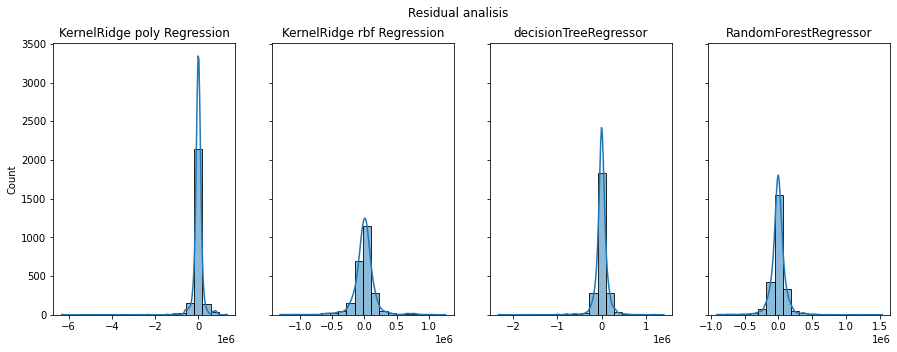

In [231]:
fig, axes = plt.subplots(1,4, figsize=(15, 5), sharey=True)
fig.suptitle('Residual analisis')
for i in range(4):
  sns.histplot((scaler_y.inverse_transform(y_val)- scaler_y.inverse_transform(predictions[i][models_name[i]])),bins=20, ax=axes[i],kde=True)
  axes[i].set_title(models_name[i])


Come si intuiva dai valori dell' MSE e dell'errore relativo il modello con i residui più bassi ossia vicini allo zero risulta essere quello derivante dall'applicazione del RandomForest. 

## Intervallo di confidenza

Verifichiamo con confidenza al 95% se lo scarto quadratico medio dei modelli è statisticamente significativo uno dall'altro.

In [232]:
from scipy import stats

In [234]:
def difference_between_two_models(error1, error2, confidence):
    z_half_alfa = stats.norm.ppf(confidence)
    variance = (((1 - error1) * error1) / len(y_val)) + (((1 - error2) * error2) / len(y_val))
    d_minus = abs(error1 - error2) - z_half_alfa * (pow(variance, 0.5))
    d_plus = abs(error1 - error2) + z_half_alfa * (pow(variance, 0.5))
    print("Valore minimo: {}\nValore massimo: {}\n".format(d_minus, d_plus))


poly_error = 1 - models[models_name[0]]["MSE"]
rbf_error = 1 - models[models_name[1]]["MSE"]
tree_error = 1 - models[models_name[2]]["MSE"]
forest_error = 1 - models[models_name[3]]["MSE"]


print("poly vs rbf, intervallo di confidenza:")
difference_between_two_models(poly_error, rbf_error, 0.95)

print("poly vs tree, intervallo di confidenza:")
difference_between_two_models(poly_error, tree_error, 0.95)

print("poly vs forest, intervallo di confidenza:")
difference_between_two_models(poly_error, forest_error, 0.95)

print("rbf vs tree, intervallo di confidenza:")
difference_between_two_models(rbf_error, tree_error, 0.95)

print("rbf vs forest, intervallo di confidenza:")
difference_between_two_models(rbf_error, forest_error, 0.95)

print("Tree vs Forest, intervallo di confidenza:")
difference_between_two_models(tree_error, forest_error, 0.95)


poly vs rbf, intervallo di confidenza:
Valore minimo: 0.016634613965850226
Valore massimo: 0.0397032515979627

poly vs tree, intervallo di confidenza:
Valore minimo: 0.034187123024038236
Valore massimo: 0.05577073365975751

poly vs forest, intervallo di confidenza:
Valore minimo: 0.04777348340973957
Valore massimo: 0.06809774449206969

rbf vs tree, intervallo di confidenza:
Valore minimo: 0.007320380062592271
Valore massimo: 0.026299611057390544

rbf vs forest, intervallo di confidenza:
Valore minimo: 0.020999775363323387
Valore massimo: 0.03853358697467295

Tree vs Forest, intervallo di confidenza:
Valore minimo: 0.005192589468841525
Valore massimo: 0.02072078174917199



Tutti gli intervalli NON contengono lo zero per una confidenza del $95\% $, la loro differenza si ritiene quindi statisticamente corretta.


#5- Analisi del modello migliore

Andiamo ora a vedere l'importanza, in temini di percentuale, che il modello RandomForest, che è risultato il migliore, assegna ad ogni features e la relativa correlazione che hanno con la variabile da predire.

In [235]:
# get importance
importance = models[models_name[3]]['Model'].named_steps['reg'].feature_importances_
# summarize feature importance
features = pd.get_dummies(final_data.drop(columns=['selling_price'])).columns

d = pd.DataFrame(importance*100, index=features, columns=['importance'])
d['correlation'] = pd.get_dummies(final_data).corr()['selling_price'][1:]
d


,importance,correlation
km_driven,2.227512,-0.219313
mileage,1.315581,-0.128241
engine,1.077636,0.454012
max_power,69.750663,0.748613
torque,4.906566,0.617312
years_driven,19.161336,-0.411791
fuel_CNG,0.199496,-0.032941
fuel_Diesel,0.645314,0.205323
fuel_LPG,0.002663,-0.036646
fuel_Petrol,0.173593,-0.195498


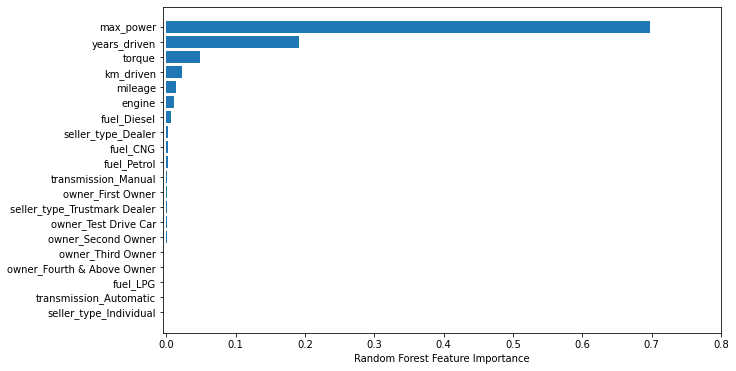

In [264]:
plt.figure(figsize=(10,6))
sorted_idx = importance.argsort()
plt.barh(features[sorted_idx], importance[sorted_idx])
plt.xlabel("Random Forest Feature Importance");
plt.xlim(-0.005, 0.8);

Si può notare che la feature a cui si assegna maggiore importanza è la potenza del motore (`max_power`) la quale ha un indice di correlazione positivo, seguita poi dagl'anni di circolazione dell'auto(`years_driven`) che sono invece inversamente proporzionali al costo dell'auto, e la coppia motore (`torque`), mentre ciò che è risultato meno importante al fine di costruire il modello predittivo risulta il venditore privato, il cambio automatico, il tipo di carburante LPG. 

L'importanza assegnata è in linea con quello che spesso avviene nella realtà dove le features più significative sono solitamente la potenza gli anni di circolazione, la coppia motore e i chilometri percorsi dall'auto 


# Test di verifica

Valutiamo ora i modelli ottenuti sui dati di Test che avevamo precedentemente isolato.

In [236]:
test_data.head()

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,years_driven
0,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.0,7
21,950000,50000,Diesel,Individual,Manual,First Owner,25.50,1498,98.60,200.0,4
42,925000,28900,Petrol,Dealer,Manual,First Owner,17.80,1497,117.30,145.0,3
62,190000,110000,Petrol,Individual,Manual,Third Owner,20.36,1197,78.90,111.7,10
83,484999,10000,Petrol,Dealer,Manual,First Owner,23.10,998,67.04,90.0,4


In [237]:
y_test = test_data['selling_price']
X_test = test_data.drop(columns="selling_price")

y_test = scaler_y.transform(y_test.values[:, None]).ravel()

for name in models_name:
  print(f"{name} model Test")
  print_eval(X_test, y_test, models[name]['Model'])
  
  print("\n================================\n")

KernelRidge poly Regression model Test
   Mean squared error: 0.066463
       Relative error: 26.59184%
R-squared coefficient: 0.94019


KernelRidge rbf Regression model Test
   Mean squared error: 0.064351
       Relative error: 25.52233%
R-squared coefficient: 0.94209


decisionTreeRegressor model Test
   Mean squared error: 0.023415
       Relative error: 18.96450%
R-squared coefficient: 0.97893


RandomForestRegressor model Test
   Mean squared error: 0.020531
       Relative error: 18.38158%
R-squared coefficient: 0.98152




Come si può vedere i modelli scelti descrivono molto bene anche i dati nuovi. In particolare RandomForest è il modello che permette di avere una buona previsione del prezzo di vendita avendo un $R^2$ pari al $98,15\%$. Tale caratteristica era visibile anche dal confronto tra Training set e Validation set.

Ovviamente nessun modello può descrivere perfettamente i dati in quanto il prezzo di vendita può essere sempre soggetto a delle trattative tra venditore e acquirente, ma nel complesso ci si può ritenere soddisfatti dei risultati ottenuti con il modello DecisionTree.